# Data Preprocessing

In [1]:
import pandas as pd
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


data = pd.read_csv('GTA6_Trailer.csv')
data['textDisplay'] = data['textDisplay'].fillna('')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)
    return text

data['processed_text'] = data['textDisplay'].apply(preprocess_text)

all_words = ' '.join(data['processed_text']).split()
word_freq = Counter(all_words)
print(data['processed_text'])
common_terms = word_freq.most_common(100)
print("Common terms:", common_terms)

0          got gta vi trailer gta vi
1                         forespoken
2                                 ku
3         youre one checking trailer
4                     realistic game
                    ...             
61380                               
61381       really long let cook boi
61382                         goated
61383             wonder end tragedy
61384    sat moment saw release date
Name: processed_text, Length: 61385, dtype: object
Common terms: [('game', 10117), ('gta', 9250), ('trailer', 7046), ('year', 5129), ('like', 4440), ('rockstar', 3894), ('time', 3288), ('im', 3009), ('wait', 2693), ('cant', 2620), ('month', 2490), ('play', 2229), ('come', 2207), ('one', 2195), ('day', 2117), ('get', 2057), ('still', 2021), ('release', 2001), ('dont', 1995), ('see', 1948), ('na', 1906), ('vi', 1864), ('view', 1825), ('gon', 1714), ('look', 1689), ('make', 1653), ('city', 1606), ('know', 1512), ('back', 1510), ('bro', 1498), ('v', 1374), ('watching', 1370), ('u', 1360), (

# Sentiment Analysis and Topic Modeling

Sentiment column created with unique values: ['neutral' 'positive' 'negative']
Topics: ['trailer rockstar game long waiting love im day moment make', 'game gta trailer time month play year come im wait', 'gta year city vi view vice million wait finally old', 'game na gon bro rockstar release pc boy yes forget', 'like look watching comment real better lol day people good']
                                         textDisplay  \
0           We got GTA VI trailer before GTA VI 🔥🔥🗣🗣   
1                          What is this forespoken 2   
2                                                 ku   
3  no, youre not the only one checking up on this...   
4                           It's More Realistic Game   

               processed_text sentiment  topic  
0   got gta vi trailer gta vi   neutral      2  
1                  forespoken   neutral      0  
2                          ku   neutral      0  
3  youre one checking trailer   neutral      4  
4              realistic game   neutral    

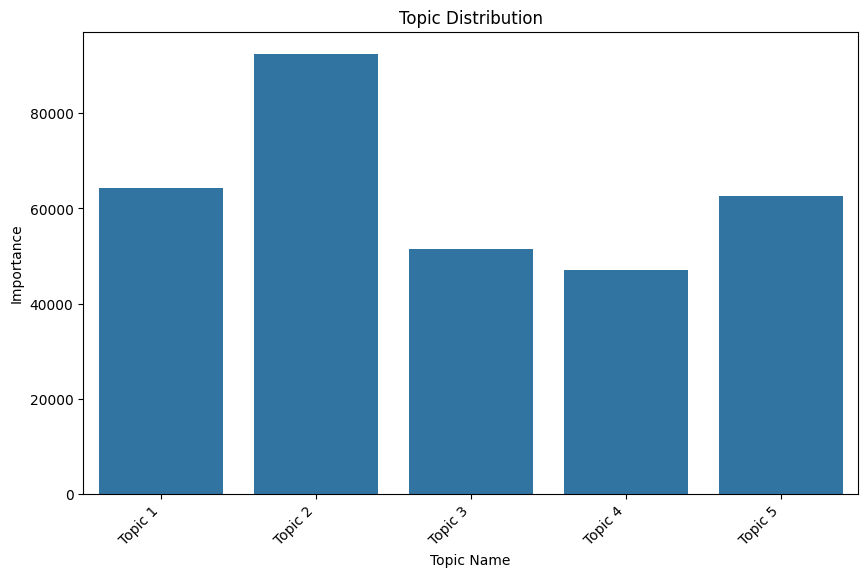

Top 10 Positive Words: [('like', 4440), ('play', 2229), ('please', 1338), ('good', 1278), ('hope', 1270), ('want', 1157), ('better', 1078), ('love', 1004), ('best', 886), ('lol', 787)]
Top 10 Negative Words: [('forget', 713), ('crazy', 617), ('ill', 599), ('betrayal', 566), ('drop', 564), ('bad', 501), ('stop', 433), ('damn', 428), ('dead', 398), ('die', 319)]
Top 10 Neutral Words: [('game', 10117), ('gta', 9250), ('trailer', 7046), ('year', 5129), ('rockstar', 3894), ('time', 3288), ('im', 3009), ('wait', 2693), ('cant', 2620), ('month', 2490)]


In [2]:
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def classify_sentiment_custom(text):
    # VADER score
    score = sia.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

data['sentiment'] = data['processed_text'].apply(classify_sentiment_custom)

print("Sentiment column created with unique values:", data['sentiment'].unique())

# Topic Modeling
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(data['processed_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topics.append(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    return topics

no_top_words = 10
topics = display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)
print("Topics:", topics)

topic_assignments = lda.transform(dtm).argmax(axis=1)
data['topic'] = topic_assignments

df_display = data[['textDisplay', 'processed_text', 'sentiment', 'topic']]
print(df_display.head())

# Save the dataframe to a CSV file
#output_file_path = 'GTA6_Trailer_Analysis.csv'
#df_display.to_csv(output_file_path, index=False)

print("Sentiment and Topic Modeling complete.")
print("Top topics identified:")
for i, topic in enumerate(topics):
    print(f"Topic {i+1}: {topic}")

plt.figure(figsize=(10, 6))
sns.barplot(x=[f'Topic {i+1}' for i in range(len(topics))], y=lda.components_.sum(axis=1))
plt.title('Topic Distribution')
plt.xlabel('Topic Name')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

all_words = [word for text in data['processed_text'] for word in text.split()]
word_sentiments = [(word, sia.polarity_scores(word)['compound']) for word in all_words]
positive_words = [word for word, sentiment in word_sentiments if sentiment > 0.05]
negative_words = [word for word, sentiment in word_sentiments if sentiment < -0.05]
neutral_words = [word for word, sentiment in word_sentiments if -0.05 <= sentiment <= 0.05]

positive_word_freq = Counter(positive_words)
negative_word_freq = Counter(negative_words)
neutral_word_freq = Counter(neutral_words)

top_10_positive_words = positive_word_freq.most_common(10)
top_10_negative_words = negative_word_freq.most_common(10)
top_10_neutral_words = neutral_word_freq.most_common(10)

print("Top 10 Positive Words:", top_10_positive_words)
print("Top 10 Negative Words:", top_10_negative_words)
print("Top 10 Neutral Words:", top_10_neutral_words)


# Top 10 Words Plotting

C:\Users\hp\AppData\Local\Temp\ipykernel_1084\3213391136.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=positive_df, palette='viridis')


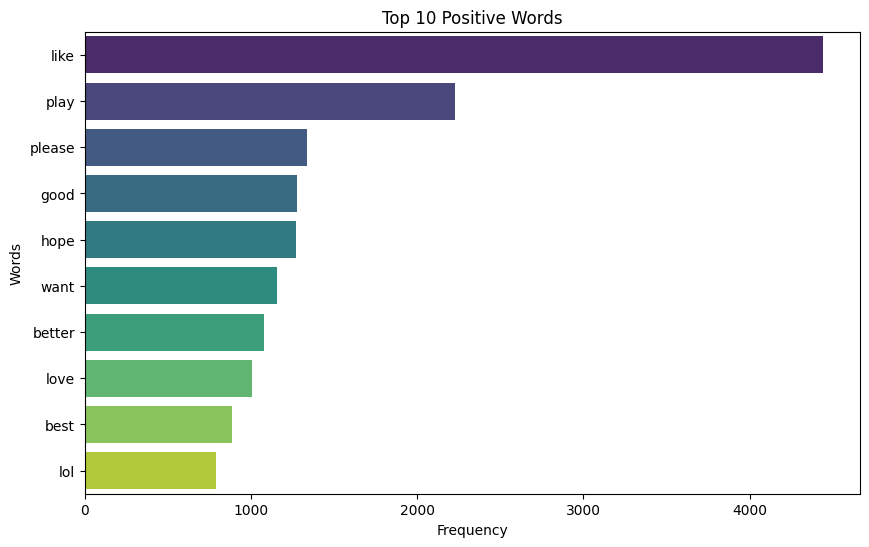

C:\Users\hp\AppData\Local\Temp\ipykernel_1084\3213391136.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=negative_df, palette='viridis')


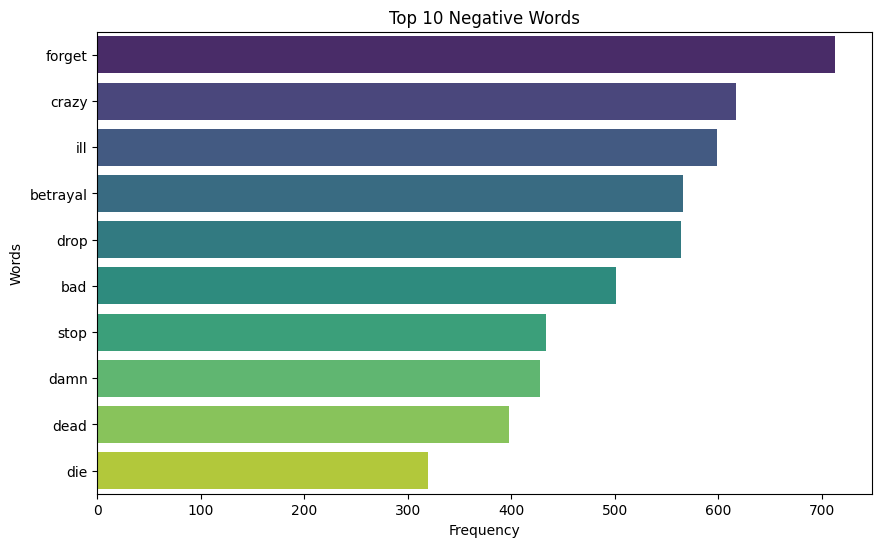

C:\Users\hp\AppData\Local\Temp\ipykernel_1084\3213391136.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=neutral_df, palette='viridis')


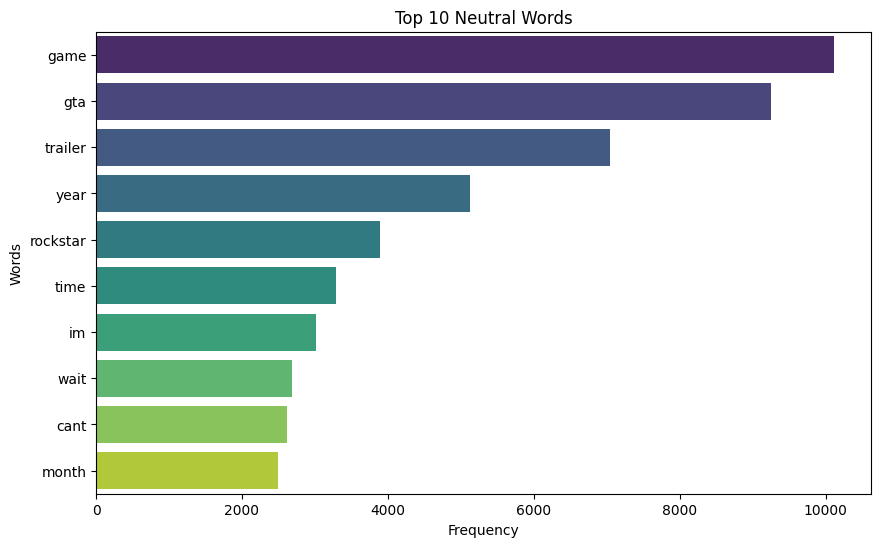

In [3]:
positive_df = pd.DataFrame(top_10_positive_words, columns=['Word', 'Frequency'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=positive_df, palette='viridis')
plt.title('Top 10 Positive Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

negative_df = pd.DataFrame(top_10_negative_words, columns=['Word', 'Frequency'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=negative_df, palette='viridis')
plt.title('Top 10 Negative Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

neutral_df = pd.DataFrame(top_10_neutral_words, columns=['Word', 'Frequency'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=neutral_df, palette='viridis')
plt.title('Top 10 Neutral Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

# Sentiment Distribution per Topic

<Figure size 1000x600 with 0 Axes>

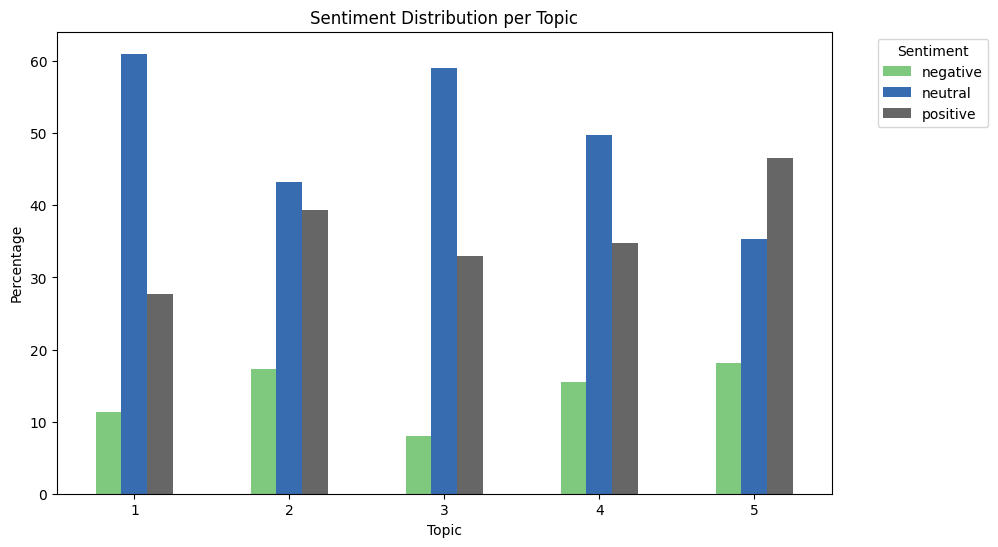

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sentiment_topic_distribution = pd.crosstab(data['topic'] + 1, data['sentiment'])
sentiment_topic_distribution = sentiment_topic_distribution.div(sentiment_topic_distribution.sum(axis=1), axis=0)
sentiment_topic_distribution = sentiment_topic_distribution * 100

plt.figure(figsize=(10, 6))
sentiment_topic_distribution.plot(kind='bar', stacked=False, colormap='Accent', figsize=(10, 6))
plt.title('Sentiment Distribution per Topic')
plt.xlabel('Topic')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Topic Trend Analysis

C:\Users\hp\AppData\Local\Temp\ipykernel_1084\2925243882.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  topic_trend_quarterly = data.groupby([pd.Grouper(key='timestamp', freq='M'), data['topic'] + 1]).size().unstack().fillna(0)


<Figure size 1400x700 with 0 Axes>

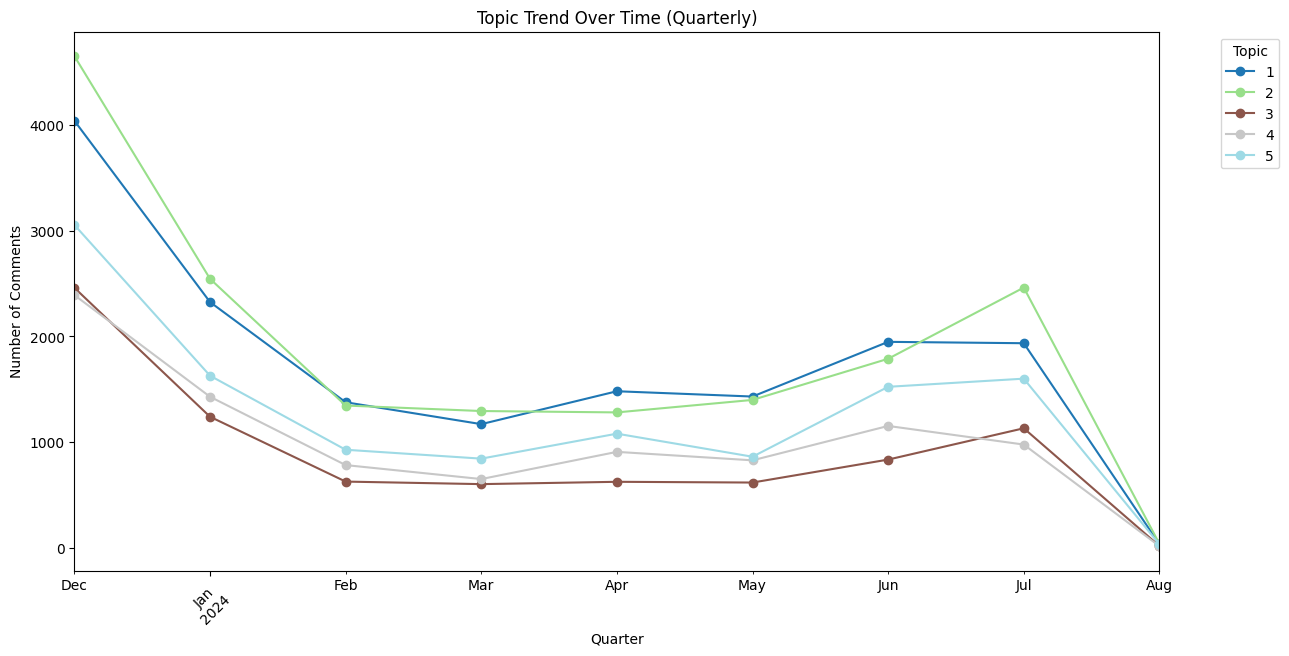

In [13]:
data['timestamp'] = pd.to_datetime(data['updatedAt'])

topic_trend_quarterly = data.groupby([pd.Grouper(key='timestamp', freq='M'), data['topic'] + 1]).size().unstack().fillna(0)


plt.figure(figsize=(14, 7))
topic_trend_quarterly.plot(figsize=(14, 7), cmap='tab20', marker='o')
plt.title('Topic Trend Over Time (Quarterly)')
plt.xlabel('Quarter')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()




                                         textDisplay  comment_type
0           We got GTA VI trailer before GTA VI 🔥🔥🗣🗣  Game-related
1                          What is this forespoken 2        Random
2                                                 ku        Random
3  no, youre not the only one checking up on this...        Random
4                           It's More Realistic Game  Game-related
Comment Type Counts:
comment_type
Random                  27902
Game-related            17288
Release-Time-related     8122
Video-related            8073
Name: count, dtype: int64


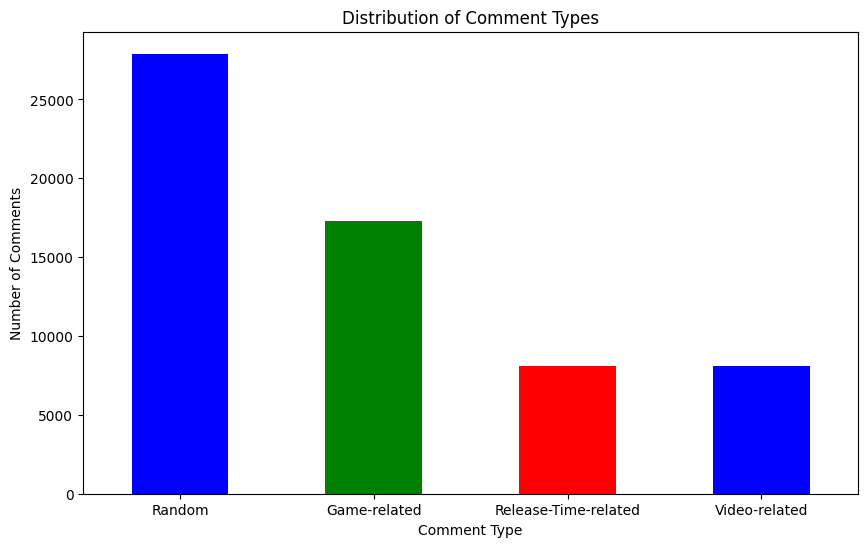

In [5]:
def classify_comment(text):
    video_keywords = [
    'video', 'watch', 'view', 'clip', 'trailer', 'movie',
    'stream', 'youtube', 'channel', 'vlog', 'reaction', 'tutorial',
    'review', 'highlight', 'footage', 'broadcast', 'episode', 'playlist',
    'live', 'subscriber', 'content', 'viral', 'upload', 'screen', 'recording',
    'short', 'film', 'documentary', 'feature', 'cinema', 'animation', 'production',
    'editing', 'effects', 'transition', 'filter', 'soundtrack', 'music video',
    'performance', 'skit', 'comedy', 'drama', 'horror', 'sci-fi', 'fantasy',
    'romance', 'action', 'thriller', 'blockbuster', 'premiere', 'teaser',
    'behind-the-scenes', 'bloopers', 'interview', 'press', 'conference', 'webisode',
    'miniseries', 'scene', 'dialogue', 'plot', 'script', 'actor', 'actress',
    'director', 'producer', 'cinematographer', 'lighting', 'camera', 'lens',
    'resolution', 'HD', '4K', 'streaming', 'buffering', 'subtitles', 'closed captions',
    'dubbed', 'voiceover', 'animation', 'CGI', 'special effects', 'green screen',
    'chroma key', 'frame rate', 'aspect ratio', 'cinematography', 'storyboard',
    'post-production', 'distribution', 'marketing', 'box office', 'ticket',
    'merchandise', 'fanbase', 'fandom', 'reviews', 'critics', 'rotten tomatoes',
    'imdb', 'film festival', 'award', 'nomination', 'screening', 'set', 'location',
    'video', 'watch', 'time', 'view', 'clip', 'trailer', 'movie', 'film', 
    'scene', 'footage', 'episode', 'series', 'documentary', 'animation', 
    'teaser', 'review', 'premiere', 'broadcast', 'visual', 'cinema', 'feature', 
    'screening', 'short', 'viral', 'upload', 'livestream', 'playback', 'recording', 
    'vlog', 'watching', 'trailer', 'coming', 'see', 'clip', 'views', 'rewatching', 
    'release'
]

    game_keywords = ['game', 'gta', 'play', 'rockstar', 'mission', 'character', 
                     'release', 'graphics', 'mod', 'update', 'console', 'PC', 'multiplayer', 
                     'story', 'campaign',
    'game', 'gta', 'play', 'rockstar', 'mission', 'character',
    'release', 'graphics', 'mod', 'update', 'console', 'PC', 'multiplayer',
    'story', 'campaign', 'heist', 'vehicle', 'map', 'sandbox', 'open-world',
    'online', 'crime', 'city', 'weapons', 'NPC', 'cheat', 'driving', 'shooting',
    'adventure', 'action', 'role-playing', 'helicopter', 'gang', 'crime spree',
    'stealth', 'combat', 'police', 'wanted level', 'carjacking', 'robbery',
    'heist', 'missions', 'side missions', 'random events', 'collectibles', 'easter eggs',
    'DLC', 'expansion pack', 'first-person', 'third-person', 'camera angle', 'cutscene',
    'dialogue', 'voice acting', 'script', 'storyline', 'plot twist', 'protagonist',
    'antagonist', 'ally', 'enemy', 'quest', 'achievement', 'trophy', 'leaderboard',
    'score', 'level', 'experience points', 'XP', 'rank', 'skill', 'ability',
    'weapon upgrade', 'armor', 'health', 'respawn', 'checkpoint', 'save game',
    'load game', 'autosave', 'inventory', 'loot', 'money', 'cash', 'economy',
    'business', 'property', 'safehouse', 'garage', 'shop', 'store', 'merchant',
    'trade', 'crafting', 'customization', 'outfit', 'disguise', 'mask',
    'multiplayer', 'co-op', 'team', 'clan', 'guild', 'voice chat', 'text chat',
    'server', 'ping', 'latency', 'host', 'client', 'matchmaking', 'lobby', 'spectator',
    'replay', 'editor', 'share', 'social club', 'achievement', 'badge', 'challenge',
    'event', 'tournament', 'competition', 'leaderboard', 'rank', 'prestige', 'season pass',
    'microtransaction', 'in-game purchase', 'virtual currency', 'beta', 'alpha', 'launch',
    'trailer', 'teaser', 'walkthrough', 'guide', 'tips', 'tricks', 'strategy', 'faq',
    'forum', 'community', 'fan site', 'modding', 'tool', 'editor', 'patch', 'hotfix',
    'update', 'maintenance', 'server downtime', 'server status', 'support', 'help', 'FAQ',
    'wiki', 'tutorial', 'how-to', 'gameplay', 'lets play', 'live stream', 'vod', 'broadcast'
]

    release_time = ['year','years',
    'coming', 'day', 'days', 'long','time', 'month', 'months', 'release_time', 
    'released', 'time', 'wait', 'waiting', 'year', 'years', 'soon', 'date', 
    'hour', 'minutes', 'delay', 'arrival', 'launch', 'release_date', 'schedule', 
    'timeline', 'deadline', 'postponed', 'upcoming', 'countdown', 'expected', 
    'approaching', 'announced', 'calendar', 'instant', 'moment', 'final', 
    'duration', 'future', 'next', 'pre-release', 'ETA', 'deferred', 'postponement', 
    'timeline', 'when', 'clock', 'timing', 'interval', 'span', 'period', 
    'temporary', 'cycle', 'elapsed', 'temporary', 'projected', 'shortly', 
    'forthcoming', 'programmed', 'set', 'anticipated', 'pending', 'clocking', 
    'continuance', 'run', 'lead_time', 'on_time', 'running_time', 'scheduled', 
    'session', 'tempo', 'whenever', 'whilst', 'forthcoming', 'time_slot', 
    'target_date', 'timeframe', 'eventually', 'past', 'interim', 'lead_up', 
    'maturity', 'pause', 'postponing', 'reminder', 'reschedule', 'rescheduled', 
    'revisit', 'time_to_time', 'timed', 'time_period', 'time-bound', 'time-sensitive', 
    'time_lag', 'timeline'
]
    
    video_score = sum([1 for word in text.split() if word in video_keywords])
    game_score = sum([1 for word in text.split() if word in game_keywords])
    release_time_score = sum([1 for word in text.split() if word in release_time])
    
    if video_score > game_score and video_score > 0:
        return 'Video-related'
    elif game_score > video_score and game_score > 0:
        return 'Game-related'
    elif release_time_score > 0:
        return 'Release-Time-related'
    else:
        return 'Random'
    
data['comment_type'] = data['processed_text'].apply(classify_comment)

print(data[['textDisplay', 'comment_type']].head())

comment_counts = data['comment_type'].value_counts()
print("Comment Type Counts:")
print(comment_counts)


plt.figure(figsize=(10, 6))
comment_counts.plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Distribution of Comment Types')
plt.xlabel('Comment Type')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)
plt.show()

#random_comments = data[data['comment_type'] == 'Random']['textDisplay']
#print(random_comments)
#random_comments.to_csv('random.csv')